## Computing the Average Possessions per Minute for all Teams in the last 20 seasons.

Using the NBA API to obtain the amount of possessions and minutes played by all teams in the NBA during the last 20 seasons.

Plotting with [Plotly Express](https://plotly.com/python/plotly-express/)

In [20]:
# All needed imports
from nba_api.stats.endpoints import leaguedashteamstats
import numpy as np
import pandas as pd
import plotly.express as px
import time


In [2]:
# Get teams possessions and minutes played for last 20 seasons
# API doesn't let us obtain for information for the 20 years, we have to call this 20 times
df = pd.DataFrame()
for i in range(20):
    # Building the Season String (ie. 2020-21)
    season_str = f"{2001 + i}-{2 + i:02d}"
    # Let's make some attempts to obtain the data, since we might be doing too many requests...
    for attempt in range(5):
        try:
            # Try to get the information for the season, getting only the columns we need
            teams = leaguedashteamstats.LeagueDashTeamStats(
                season=season_str, measure_type_detailed_defense="Advanced",
            ).get_data_frames()[0][["TEAM_ID", "TEAM_NAME", "MIN", "POSS"]]
        except:
            # If we get an error we go to sleep for some time
            time.sleep(30)
        else:
            # If everything's OK with the request, we continue
            break

    if len(teams):
        teams["SEASON"] = season_str
        df = pd.concat([df, teams], axis=0)
    else:
        print("Try again :(")
        break

df.head()

,TEAM_ID,TEAM_NAME,GP,MIN,POSS,SEASON
0,1610612737,Atlanta Hawks,82,3956.0,7678,2001-02
1,1610612738,Boston Celtics,82,3966.0,7738,2001-02
2,1610612766,Charlotte Hornets,82,3951.0,7480,2001-02
3,1610612741,Chicago Bulls,82,3961.0,7549,2001-02
4,1610612739,Cleveland Cavaliers,82,3971.0,7553,2001-02


In [3]:
# Get possessions per minute for every row.
df["POSS_PER_MIN"] = df["POSS"] / df["MIN"]

In [13]:
# Get the average possessions per minute for the league in each season.
poss_per_min_series = df.groupby("SEASON")["POSS_PER_MIN"].mean()
poss_per_min_df = pd.DataFrame(poss_per_min_series)
# Transform the index
poss_per_min_df.index = pd.to_numeric(poss_per_min_df.index.str[:4])

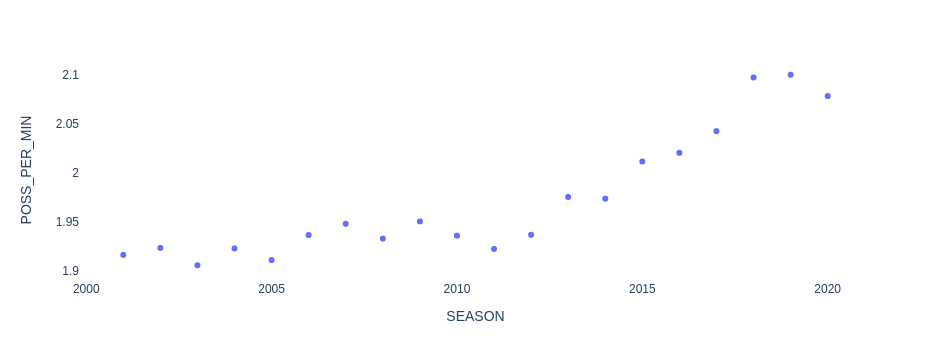

In [26]:
# Plot
fig = px.scatter(poss_per_min_df, x=poss_per_min_df.index, y=poss_per_min_df["POSS_PER_MIN"])
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)
fig.show()

### Conclusions
We can see that the playing pace has increased from the 2015 season and on, but thi